In [1]:
import os
from datetime import datetime

import re
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

import autogluon.core as ag
from autogluon.tabular import TabularDataset, TabularPredictor
import autogluon.features.generators as f

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binned_statistic
from multilabel import MultilabelPredictor


### Compare distributions for train and test set across all variables then prune the train set

### Design the test set to resemble the public test

In [ ]:
df = pd.read_csv('train.csv')
df

### Lets visualize the starting points for each trip called from a taxi stand

In [5]:
# Start by calculating the LEN for each trip
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15


# Get starting location from polyline
def extract_first_coords(x):
  # Extract the first pair of coordinates using regex
  match = re.search('\[(-?\d+\.\d+),(-?\d+\.\d+)\]', x['POLYLINE'])
  if match:
      lon = float(match.group(1))
      lat = float(match.group(2))
      return lat, lon
  else:
      return None, None


# Get the origin stand locations
def origin_stand_location(x, coords):
  standID = x['ORIGIN_STAND']
  if np.isnan(standID):
    return None, None
  
  return coords['Latitude'][standID], coords['Longitude'][standID]


# Remove rows with missing values in col from df
def remove_missing_rows(df, col):
  return df[df[col].notna()]

# Get month, day of week, and hour from TIMESTAMP
def expand_time(x):
  dt = datetime.fromtimestamp(x['TIMESTAMP'])
  return dt.month, dt.day, dt.weekday(), dt.hour


In [6]:
# Create a copy of the df
locationdf = pd.read_csv('train.csv')

# Calculate LEN and add it to the df
len = locationdf['POLYLINE'].apply(polyline_to_trip_duration)
locationdf['LEN'] = len

# Remove outliers
# Trips must be at least 1 minute and less than 3 standard deviations above the mean
locationdf = locationdf[(len < len.mean() + 3 * len.std()) & (len >= 60)]

In [7]:
# Get the starting location of the trip
locationdf[['startLAT', 'startLON']] = locationdf[['POLYLINE']].apply(extract_first_coords, axis=1, result_type='expand')

In [8]:
# Create a dictionary for origin stand locations
coords = pd.read_csv('metaData_taxistandsID_name_GPSlocation.csv').set_index('ID').to_dict()

# Add origin stand locations to the df
locationdf[['standLAT','standLON']] = locationdf[['ORIGIN_STAND']].apply(origin_stand_location, args=(coords,),
                                                                         axis=1, result_type='expand')

locationdf.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,startLAT,startLON,standLAT,standLON
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,41.141412,-8.618643,NaN,NaN
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,41.159826,-8.639847,41.15998,-8.641984
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,41.140359,-8.612964,NaN,NaN
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,41.151951,-8.574678,NaN,NaN
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,41.180490,-8.645994,NaN,NaN


In [9]:
# Remove rows with missing data
locationdf = locationdf[~locationdf['MISSING_DATA']]

# Remove columns
locationdf.drop(columns=['TRIP_ID','ORIGIN_CALL','DAY_TYPE','MISSING_DATA','POLYLINE'], inplace=True)

locationdf.head()

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,TIMESTAMP,LEN,startLAT,startLON,standLAT,standLON
0,C,NaN,20000589,1372636858,330,41.141412,-8.618643,NaN,NaN
1,B,7.0,20000596,1372637303,270,41.159826,-8.639847,41.15998,-8.641984
2,C,NaN,20000320,1372636951,960,41.140359,-8.612964,NaN,NaN
3,C,NaN,20000520,1372636854,630,41.151951,-8.574678,NaN,NaN
4,C,NaN,20000337,1372637091,420,41.180490,-8.645994,NaN,NaN


In [10]:
locationdf[['MON','DAY','WK','HR']] = locationdf[['TIMESTAMP']].apply(expand_time, axis=1, result_type='expand')

locationdf.head()

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,TIMESTAMP,LEN,startLAT,startLON,standLAT,standLON,MON,DAY,WK,HR
0,C,NaN,20000589,1372636858,330,41.141412,-8.618643,NaN,NaN,6,30,6,17
1,B,7.0,20000596,1372637303,270,41.159826,-8.639847,41.15998,-8.641984,6,30,6,17
2,C,NaN,20000320,1372636951,960,41.140359,-8.612964,NaN,NaN,6,30,6,17
3,C,NaN,20000520,1372636854,630,41.151951,-8.574678,NaN,NaN,6,30,6,17
4,C,NaN,20000337,1372637091,420,41.180490,-8.645994,NaN,NaN,6,30,6,17


In [11]:
# Keep only the last 3 digits of taxi id for simplicity
locationdf['TAXI_ID'] = locationdf['TAXI_ID'] % 1000

* * *
### Try Imputing Start Location from ORIGIN_STAND metadata if available
We can compare the trip start locations against origin stands to see if we can use origin stand location as the start if they are close

In [12]:
# Lets see how close the origin stands are to the start of the trip
stands = locationdf[locationdf['CALL_TYPE']=='B'].groupby('ORIGIN_STAND').agg({
    'standLAT':'first',
    'standLON':'first',
    'startLAT':['mean','min','max'],
    'startLON':['mean','min','max'],
    'LEN':['mean','median']
})
stands.columns = ["_".join(a) for a in stands.columns.to_flat_index()]
stands.head()

,standLAT_first,standLON_first,startLAT_mean,startLAT_min,startLAT_max,startLON_mean,startLON_min,startLON_max,LEN_mean,LEN_median
ORIGIN_STAND,,,,,,,,,,
1.0,41.177146,-8.609670,41.177268,41.171319,41.215176,-8.609423,-8.655579,-8.599500,636.560582,570.0
2.0,41.156190,-8.591064,41.156214,41.147244,41.204088,-8.591415,-8.620839,-8.585523,723.423773,630.0
3.0,41.170525,-8.665876,41.170687,41.158800,41.177700,-8.665599,-8.666397,-8.613729,625.493139,555.0
4.0,41.143764,-8.621803,41.143633,41.141133,41.145165,-8.621555,-8.624232,-8.610669,681.090026,615.0
5.0,41.183510,-8.612726,41.182484,41.140395,41.183955,-8.613097,-8.613747,-8.612217,638.333333,510.0


In [13]:
# Origin stands ended up being very very close to trip start locations on average
# We can just use origin stand coords instead of trying to predict start location

def dfError(df, col1, col2, metric='mse'):
    if metric == 'mae':
        return abs(df[col1]-df[col2]).sum() / df.shape[0]
    return np.square(df[col1]-df[col2]).sum() / df.shape[0]

print(f"Latitude MSE: {dfError(stands, 'standLAT_first', 'startLAT_mean')}")
print(f"Longitude MSE: {dfError(stands, 'standLON_first', 'startLON_mean')}")

print(f"Latitude MAE: {dfError(stands, 'standLAT_first', 'startLAT_mean', metric='mae')}")
print(f"Longitude MAE: {dfError(stands, 'standLON_first', 'startLON_mean', metric='mae')}")

Latitude MSE: 1.5238062118781542e-07
Longitude MSE: 2.3321733180192545e-07
Latitude MAE: 0.00024381651302086816
Longitude MAE: 0.00032318158090282803


These values translate to less than 100 meters which is accurate enough for this model

* * * 
### Try Imputing Start Location from Averaging over CALL_TYPE and Time features

In [14]:
# Now lets create a dataset to train a model to predict starting location

# First model will be multilabel regression
# Can also try k-means clustering to group common locations in the city and assign them each a label for a classification model

predict_locations = locationdf.copy().drop(columns=['standLAT','standLON','LEN','TIMESTAMP','ORIGIN_STAND'])
predict_locations = predict_locations[predict_locations['CALL_TYPE'] != 'B']

predict_locations.head()

,CALL_TYPE,TAXI_ID,startLAT,startLON,MON,DAY,WK,HR
0,C,589,41.141412,-8.618643,6,30,6,17
2,C,320,41.140359,-8.612964,6,30,6,17
3,C,520,41.151951,-8.574678,6,30,6,17
4,C,337,41.180490,-8.645994,6,30,6,17
5,C,231,41.140674,-8.615502,6,30,6,17


In [15]:
# Create a dictionary of the mean lat/lon for every combination of CALL_TYPE, month, weekday, hour
coordlookup = predict_locations.groupby(['CALL_TYPE','MON','WK','HR'])[['startLAT','startLON']].mean()
coorddict = coordlookup.to_dict()

### Add the starting coordinates from the stand metadata

In [16]:
def getCoords(calltype, mon, wk, hr, coords):
    lat = coords['startLAT'][(calltype, mon, wk, hr)]
    lon = coords['startLON'][(calltype, mon, wk, hr)]
    return lat, lon

testgetcoords = predict_locations.copy()

testgetcoords[['predLAT','predLON']] = testgetcoords.apply(lambda x: getCoords(x['CALL_TYPE'],x['MON'],x['WK'],x['HR'],coorddict),
                                                           axis=1, result_type='expand')


testgetcoords.head()

,CALL_TYPE,TAXI_ID,startLAT,startLON,MON,DAY,WK,HR,predLAT,predLON
0,C,589,41.141412,-8.618643,6,30,6,17,41.153736,-8.616902
2,C,320,41.140359,-8.612964,6,30,6,17,41.153736,-8.616902
3,C,520,41.151951,-8.574678,6,30,6,17,41.153736,-8.616902
4,C,337,41.180490,-8.645994,6,30,6,17,41.153736,-8.616902
5,C,231,41.140674,-8.615502,6,30,6,17,41.153736,-8.616902


In [17]:
evalpred = testgetcoords
print(f"Latitude MSE: {dfError(evalpred, 'predLAT', 'startLAT')}")
print(f"Longitude MSE: {dfError(evalpred, 'predLON', 'startLON')}")

print(f"Latitude MAE: {dfError(evalpred, 'predLAT', 'startLAT', metric='mae')}")
print(f"Longitude MAE: {dfError(evalpred, 'predLON', 'startLON', metric='mae')}")

Latitude MSE: 0.00048615082149988854
Longitude MSE: 0.0008934820001226968
Latitude MAE: 0.010142485267217696
Longitude MAE: 0.021384871800082025


Not so accurate this time, the MAE corresponds to up to about 2 miles, we need something better

* * *
## Training an ML model to predict the starting locations

We will use an ensemble gradient boosting multilabel regression model to predict the start locations (lat/lon) for rows where its missing

In [18]:
locationdf.head()

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,TIMESTAMP,LEN,startLAT,startLON,standLAT,standLON,MON,DAY,WK,HR
0,C,NaN,589,1372636858,330,41.141412,-8.618643,NaN,NaN,6,30,6,17
1,B,7.0,596,1372637303,270,41.159826,-8.639847,41.15998,-8.641984,6,30,6,17
2,C,NaN,320,1372636951,960,41.140359,-8.612964,NaN,NaN,6,30,6,17
3,C,NaN,520,1372636854,630,41.151951,-8.574678,NaN,NaN,6,30,6,17
4,C,NaN,337,1372637091,420,41.180490,-8.645994,NaN,NaN,6,30,6,17


In [42]:
import io
import logging
import pickle
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common.utils.utils import setup_outputdir
from autogluon.core.utils.loaders import load_pkl
from autogluon.core.utils.savers import save_pkl
from sklearn.model_selection import train_test_split
import autogluon as ag
import os.path

from ..loaders import load_pointer
from ..utils import compression_utils, s3_utils
import s3_utils as s3_utils


logger = logging.getLogger(__name__)


def load(path, format=None, verbose=True, **kwargs):
    compression_fn = kwargs.get('compression_fn', None)
    compression_fn_kwargs = kwargs.get('compression_fn_kwargs', None)

    if path.endswith('.pointer'):
        format = 'pointer'
    elif s3_utils.is_s3_url(path):
        format = 's3'
    if format == 'pointer':
        content_path = load_pointer.get_pointer_content(path)
        if content_path == path:
            raise RecursionError('content_path == path! : ' + str(path))
        return load(path=content_path)
    elif format == 's3':
        import boto3
        if verbose:
            logger.log(15, 'Loading: %s' % path)
        s3_bucket, s3_prefix = s3_utils.s3_path_to_bucket_prefix(s3_path=path)
        s3 = boto3.resource('s3')
        return pickle.loads(s3.Bucket(s3_bucket).Object(s3_prefix).get()['Body'].read())

    if verbose:
        logger.log(15, 'Loading: %s' % path)

    compression_fn_map = compression_utils.get_compression_map()
    validated_path = compression_utils.get_validated_path(path, compression_fn=compression_fn)

    if compression_fn_kwargs is None:
        compression_fn_kwargs = {}

    if compression_fn in compression_fn_map:
        with compression_fn_map[compression_fn]['open'](validated_path, 'rb', **compression_fn_kwargs) as fin:
            print(fin)
            object = pickle.load(fin)
    else:
        raise ValueError(
            f'compression_fn={compression_fn} or compression_fn_kwargs={compression_fn_kwargs} are not valid.'
            f' Valid function values: {compression_fn_map.keys()}')

    return object


def load_with_fn(path, pickle_fn, format=None, verbose=True):
    if path.endswith('.pointer'):
        format = 'pointer'
    elif s3_utils.is_s3_url(path):
        format = 's3'
    if format == 'pointer':
        content_path = load_pointer.get_pointer_content(path)
        if content_path == path:
            raise RecursionError('content_path == path! : ' + str(path))
        return load_with_fn(content_path, pickle_fn)
    elif format == 's3':
        import boto3
        if verbose:
            logger.log(15, 'Loading: %s' % path)
        s3_bucket, s3_prefix = s3_utils.s3_path_to_bucket_prefix(s3_path=path)
        s3 = boto3.resource('s3')
        # Has to be wrapped in IO buffer since s3 stream does not implement seek()
        buff = io.BytesIO(s3.Bucket(s3_bucket).Object(s3_prefix).get()['Body'].read())
        return pickle_fn(buff)

    if verbose:
        logger.log(15, 'Loading: %s' % path)
    with open(path, 'rb') as fin:
        object = pickle_fn(fin)
    return object


ImportError: attempted relative import with no known parent package

In [43]:
import pickle
class MultilabelPredictor():
    """ Tabular Predictor for predicting multiple columns in table.
        Creates multiple TabularPredictor objects which you can also use individually.
        You can access the TabularPredictor for a particular label via: `multilabel_predictor.get_predictor(label_i)`

        Parameters
        ----------
        labels : List[str]
            The ith element of this list is the column (i.e. `label`) predicted by the ith TabularPredictor stored in this object.
        path : str, default = None
            Path to directory where models and intermediate outputs should be saved.
            If unspecified, a time-stamped folder called "AutogluonModels/ag-[TIMESTAMP]" will be created in the working directory to store all models.
            Note: To call `fit()` twice and save all results of each fit, you must specify different `path` locations or don't specify `path` at all.
            Otherwise files from first `fit()` will be overwritten by second `fit()`.
            Caution: when predicting many labels, this directory may grow large as it needs to store many TabularPredictors.
        problem_types : List[str], default = None
            The ith element is the `problem_type` for the ith TabularPredictor stored in this object.
        eval_metrics : List[str], default = None
            The ith element is the `eval_metric` for the ith TabularPredictor stored in this object.
        consider_labels_correlation : bool, default = True
            Whether the predictions of multiple labels should account for label correlations or predict each label independently of the others.
            If True, the ordering of `labels` may affect resulting accuracy as each label is predicted conditional on the previous labels appearing earlier in this list (i.e. in an auto-regressive fashion).
            Set to False if during inference you may want to individually use just the ith TabularPredictor without predicting all the other labels.
        kwargs :
            Arguments passed into the initialization of each TabularPredictor.

    """

    multi_predictor_file = 'multilabel_predictor.pkl'

    def __init__(self, labels, path=None, problem_types=None, eval_metrics=None, consider_labels_correlation=True, **kwargs):
        if len(labels) < 2:
            raise ValueError("MultilabelPredictor is only intended for predicting MULTIPLE labels (columns), use TabularPredictor for predicting one label (column).")
        if (problem_types is not None) and (len(problem_types) != len(labels)):
            raise ValueError("If provided, `problem_types` must have same length as `labels`")
        if (eval_metrics is not None) and (len(eval_metrics) != len(labels)):
            raise ValueError("If provided, `eval_metrics` must have same length as `labels`")
        self.path = setup_outputdir(path, warn_if_exist=False)
        self.labels = labels
        self.consider_labels_correlation = consider_labels_correlation
        self.predictors = {}  # key = label, value = TabularPredictor or str path to the TabularPredictor for this label
        if eval_metrics is None:
            self.eval_metrics = {}
        else:
            self.eval_metrics = {labels[i] : eval_metrics[i] for i in range(len(labels))}
        problem_type = None
        eval_metric = None
        for i in range(len(labels)):
            label = labels[i]
            path_i = self.path + "Predictor_" + label
            if problem_types is not None:
                problem_type = problem_types[i]
            if eval_metrics is not None:
                eval_metric = eval_metrics[i]
            self.predictors[label] = TabularPredictor(label=label, problem_type=problem_type, eval_metric=eval_metric, path=path_i, **kwargs)

    def fit(self, train_data, tuning_data=None, **kwargs):
        """ Fits a separate TabularPredictor to predict each of the labels.

            Parameters
            ----------
            train_data, tuning_data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                See documentation for `TabularPredictor.fit()`.
            kwargs :
                Arguments passed into the `fit()` call for each TabularPredictor.
        """
        if isinstance(train_data, str):
            train_data = TabularDataset(train_data)
        if tuning_data is not None and isinstance(tuning_data, str):
            tuning_data = TabularDataset(tuning_data)
        train_data_og = train_data.copy()
        if tuning_data is not None:
            tuning_data_og = tuning_data.copy()
        else:
            tuning_data_og = None
        save_metrics = len(self.eval_metrics) == 0
        for i in range(len(self.labels)):
            label = self.labels[i]
            predictor = self.get_predictor(label)
            if not self.consider_labels_correlation:
                labels_to_drop = [l for l in self.labels if l != label]
            else:
                labels_to_drop = [self.labels[j] for j in range(i+1, len(self.labels))]
            train_data = train_data_og.drop(labels_to_drop, axis=1)
            if tuning_data is not None:
                tuning_data = tuning_data_og.drop(labels_to_drop, axis=1)
            print(f"Fitting TabularPredictor for label: {label} ...")
            predictor.fit(train_data=train_data, tuning_data=tuning_data, **kwargs)
            self.predictors[label] = predictor.path
            if save_metrics:
                self.eval_metrics[label] = predictor.eval_metric
        self.save()

    def predict(self, data, **kwargs):
        """ Returns DataFrame with label columns containing predictions for each label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. If label columns are present in this data, they will be ignored. See documentation for `TabularPredictor.predict()`.
            kwargs :
                Arguments passed into the predict() call for each TabularPredictor.
        """
        return self._predict(data, as_proba=False, **kwargs)

    def predict_proba(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `predict_proba()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. See documentation for `TabularPredictor.predict()` and `TabularPredictor.predict_proba()`.
            kwargs :
                Arguments passed into the `predict_proba()` call for each TabularPredictor (also passed into a `predict()` call).
        """
        return self._predict(data, as_proba=True, **kwargs)

    def evaluate(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `evaluate()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to evalate predictions of all labels for, must contain all labels as columns. See documentation for `TabularPredictor.evaluate()`.
            kwargs :
                Arguments passed into the `evaluate()` call for each TabularPredictor (also passed into the `predict()` call).
        """
        data = self._get_data(data)
        eval_dict = {}
        for label in self.labels:
            print(f"Evaluating TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            eval_dict[label] = predictor.evaluate(data, **kwargs)
            if self.consider_labels_correlation:
                data[label] = predictor.predict(data, **kwargs)
        return eval_dict

    def save(self):
        """ Save MultilabelPredictor to disk. """
        for label in self.labels:
            if not isinstance(self.predictors[label], str):
                self.predictors[label] = self.predictors[label].path
        save_pkl.save(path=self.path+self.multi_predictor_file, object=self)
        print(f"MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('{self.path}')")

    @classmethod
    def load(cls, path):
        """ Load MultilabelPredictor from disk `path` previously specified when creating this MultilabelPredictor. """
        path = os.path.expanduser(path)
        if path[-1] != os.path.sep:
            path = path + os.path.sep
        return load(path=path+cls.multi_predictor_file)

    def get_predictor(self, label):
        """ Returns TabularPredictor which is used to predict this label. """
        predictor = self.predictors[label]
        if isinstance(predictor, str):
            return TabularPredictor.load(path=predictor)
        return predictor

    def _get_data(self, data):
        if isinstance(data, str):
            return TabularDataset(data)
        return data.copy()

    def _predict(self, data, as_proba=False, **kwargs):
        data = self._get_data(data)
        if as_proba:
            predproba_dict = {}
        for label in self.labels:
            print(f"Predicting with TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            if as_proba:
                predproba_dict[label] = predictor.predict_proba(data, as_multiclass=True, **kwargs)
            data[label] = predictor.predict(data, **kwargs)
        if not as_proba:
            return data[self.labels]
        else:
            return predproba_dict
        
def load(path, format=None, compression_fn=None, verbose=True):
    if path.endswith('.pointer'):
        format = 'pointer'
    elif s3_utils.is_s3_url(path):
        format = 's3'
    if format == 'pointer':
        content_path = load_pointer.get_pointer_content(path)
        if content_path == path:
            raise RecursionError('content_path == path! : ' + str(path))
        return load(path=content_path)
    elif format == 's3':
        if verbose: logger.log(15, 'Loading: %s' % path)
        s3_bucket, s3_prefix = s3_utils.s3_path_to_bucket_prefix(s3_path=path)
        s3 = boto3.resource('s3')
        return pickle.loads(s3.Bucket(s3_bucket).Object(s3_prefix).get()['Body'].read())

    if verbose: logger.log(15, 'Loading: %s' % path)
    if compression_fn in compression_fn_map:
        with compression_fn_map[compression_fn](path, 'rb') as fin:
            object = pickle.load(fin)
    else:
        raise ValueError(f'compression_fn={compression_fn} is not a valid compression_fn. Valid values: {compression_fn_map.keys()}')
    return objec

In [44]:
locationPredictionData = TabularDataset(locationdf)

locationPredictor = MultilabelPredictor.load('AutogluonModels/ag-20230611_193339')


NameError: name 's3_utils' is not defined

In [435]:
# Multilabel Regression
#from multilabel import MultilabelPredictor
'''
# Create gluon training data object
multireg_train = TabularDataset('predict_locations.csv')

multireg_train, multireg_test = train_test_split(multireg_train, test_size=0.1)

# Set taxi id to be a categorical feature, rest is auto inferred
multireg_train['TAXI_ID'] = multireg_train['TAXI_ID'].astype('category')

# Setting up the hyperparameters for the training job
labels = ['startLAT','startLON']
problem_types = ['regression','regression']
eval_metrics = ['mean_absolute_error','mean_absolute_error']

# Create the multi predictor object
multiPredictor = MultilabelPredictor(labels=labels, problem_types=problem_types, eval_metrics=eval_metrics)

cat_params = {
    'iterations': 500,
    'depth': ag.space.Int(lower=5, upper=10, default=7),
}

xgb_params = {
    'n_estimators': 100,
    'max_depth': ag.space.Int(lower=5, upper=10, default=7),
}

gbm_params = {
    'num_boost_round': 100,  
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),
}

hyperparameter_tune_kwargs = {
    'num_trials': 10,
    'scheduler' : 'local',
    'searcher': 'auto',
}

multiPredictor.fit(
    multireg_train,
    presets=['good_quality'],
    excluded_model_types=['NN_TORCH','FASTAI']
    #hyperparameters={'XGB':xgb_params, 'CAT':cat_params, 'GBM':gbm_params},
    #yperparameter_tune_kwargs='auto',
    #ag_args_fit={'num_gpus': 'auto'}
)
'''

"\n# Create gluon training data object\nmultireg_train = TabularDataset('predict_locations.csv')\n\nmultireg_train, multireg_test = train_test_split(multireg_train, test_size=0.1)\n\n# Set taxi id to be a categorical feature, rest is auto inferred\nmultireg_train['TAXI_ID'] = multireg_train['TAXI_ID'].astype('category')\n\n# Setting up the hyperparameters for the training job\nlabels = ['startLAT','startLON']\nproblem_types = ['regression','regression']\neval_metrics = ['mean_absolute_error','mean_absolute_error']\n\n# Create the multi predictor object\nmultiPredictor = MultilabelPredictor(labels=labels, problem_types=problem_types, eval_metrics=eval_metrics)\n\ncat_params = {\n    'iterations': 500,\n    'depth': ag.space.Int(lower=5, upper=10, default=7),\n}\n\nxgb_params = {\n    'n_estimators': 100,\n    'max_depth': ag.space.Int(lower=5, upper=10, default=7),\n}\n\ngbm_params = {\n    'num_boost_round': 100,  \n    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),\n}\n\n

* * *
## Adversarial Validation
### Use a Random Forest Classifier to discriminate between the training and testing sets

In [16]:
# Adversarial Validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import roc_auc_score

def compareDistRF(df):
    # Copy the DataFrame
    df_copy = df.copy()
    
    # Split into features and target
    X = df_copy.drop('is_test', axis=1).fillna(-1)
    y = df_copy['is_test']

    # Train a Random Forest Classifier
    clf = RandomForestClassifier(random_state=42,max_depth=2,class_weight='balanced')
    clf.fit(X, y)

    # Create a dataframe with feature importance data
    feature_importance = pd.DataFrame({
        'Feature':list(X.columns),
        'RF_Score':list(clf.feature_importances_)
    })

    feature_importance = feature_importance.sort_values(by='RF_Score', ascending=False)

    # Predict probabilities
    probs = clf.predict_proba(X)[:, 1]

    # Calculate AUC-ROC scores
    auc = roc_auc_score(y, probs)

    print(f"Train AUC-ROC: {auc}")

    # Add probabilities to the original DataFrame
    df_copy['prob_is_test'] = probs

    # Sort the DataFrame by the probabilities
    df_sorted = df_copy.sort_values(by='prob_is_test', ascending=False)

    # Return the sorted DataFrame
    return df_sorted, feature_importance

### Read the public test data and concat with train

In [17]:
test_public = pd.read_csv('test_public.csv').set_index('TRIP_ID')

test_public[['MON','DAY','WK','HR']] = test_public[['TIMESTAMP']].apply(expand_time, axis=1, result_type='expand')
test_public['TAXI_ID'] = test_public['TAXI_ID'] % 1000
test_public.drop(columns=['ORIGIN_CALL','DAY_TYPE','MISSING_DATA','TIMESTAMP'], inplace=True)
test_public

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,MON,DAY,WK,HR
TRIP_ID,,,,,,,
T1,B,15.0,542,8,14,3,10
T2,B,57.0,108,8,14,3,10
T3,B,15.0,370,8,14,3,10
T4,B,53.0,492,8,14,3,10
T5,B,18.0,621,8,14,3,10
...,...,...,...,...,...,...,...
T323,A,NaN,430,12,21,6,6
T324,B,53.0,20,12,21,6,6
T325,C,NaN,207,12,21,6,6


We can start filtering the data now. To try and better match the training and test sets, we will only include rows where the TAXI_ID and MON also appear in the test set. We already removed outliers for trip time earlier. We will also one-hot encode CALL_TYPE

In [18]:
# Create the training comparison df
compare_dist_train = locationdf.copy().drop(columns=['TIMESTAMP','startLAT','startLON','standLAT','standLON','LEN'])

# Public test comparison df
compare_dist_test = test_public

# Only include taxi_id that are present in the test data
common_taxi_ids = set(compare_dist_train['TAXI_ID']).intersection(set(compare_dist_test['TAXI_ID']))
compare_dist_train = compare_dist_train[compare_dist_train['TAXI_ID'].isin(common_taxi_ids)]

# Only include months that show up in both
common_mon = set(compare_dist_train['MON']).intersection(set(compare_dist_test['MON']))
compare_dist_train = compare_dist_train[compare_dist_train['MON'].isin(common_mon)]

# Add labels for adversarial validation
compare_dist_train['is_test'] = 0
compare_dist_test['is_test'] = 1

# Combine the dataframes
compare_dist_df = pd.concat([compare_dist_train, compare_dist_test]).sample(frac=1)

# Get one hot encoding of CALL_TYPE
one_hot = pd.get_dummies(compare_dist_df['CALL_TYPE'])
compare_dist_df = one_hot.join(compare_dist_df.drop(columns=['CALL_TYPE']))

compare_dist_df

,A,B,C,ORIGIN_STAND,TAXI_ID,MON,DAY,WK,HR,is_test
251383,False,True,False,10.0,190,8,26,0,10,0
466412,False,True,False,15.0,177,10,10,3,4,0
561603,False,False,True,NaN,328,10,29,1,10,0
806587,True,False,False,NaN,158,12,20,4,10,0
408666,False,True,False,53.0,129,9,28,5,14,0
...,...,...,...,...,...,...,...,...,...,...
424347,False,False,True,NaN,188,10,1,1,11,0
734438,False,False,True,NaN,450,12,5,3,19,0
527570,False,True,False,6.0,123,10,22,1,7,0
839083,False,True,False,15.0,561,12,27,4,11,0


### Run the adversarial validation tests

We want this model to perform poorly, it indicates well matched sets

In [19]:
compareProbRF, featImps = compareDistRF(compare_dist_df)
featImps

Train AUC-ROC: 0.9556078924095683


,Feature,RF_Score
6,DAY,0.381780
8,HR,0.277981
7,WK,0.161645
5,MON,0.136293
1,B,0.018211
2,C,0.014255
4,TAXI_ID,0.004940
3,ORIGIN_STAND,0.003583
0,A,0.001313


**AUC score closer to 1 means the model is better at classifying**  
**We don't want this since it could lead to our future model overfitting the training data**  
**The model is easily able to classify between test and train based on the DAY variable**  
**Lets drop it and see what happens**  

In [20]:
compareProbRF, featImps = compareDistRF(compare_dist_df.drop(['DAY'], axis=1))
featImps

Train AUC-ROC: 0.8581358359628013


,Feature,RF_Score
7,HR,0.341474
5,MON,0.256865
6,WK,0.203779
3,ORIGIN_STAND,0.061761
1,B,0.060129
2,C,0.040209
4,TAXI_ID,0.022504
0,A,0.013280


In [231]:
# Lets drop the day column
compare_dist_train.drop(['DAY'], axis=1, inplace=True)
compare_dist_test.drop(['DAY'], axis=1, inplace=True)

In [298]:
# The dataframe is sorted in order of which data the model gives the highest probability of coming from the test set
compareProbRF[(compareProbRF['is_test']==0) & (compareProbRF['prob_is_test'] > 0.5)]

,A,B,C,ORIGIN_STAND,TAXI_ID,MON,WK,HR,is_test,prob_is_test
494263,False,False,True,NaN,126,10,1,10,0,0.631616
528333,False,False,True,NaN,129,10,1,10,0,0.631616
558793,False,False,True,NaN,136,10,0,10,0,0.631616
522933,False,False,True,NaN,163,10,0,10,0,0.631616
422712,False,False,True,NaN,207,10,1,10,0,0.631616
...,...,...,...,...,...,...,...,...,...,...
340418,True,False,False,NaN,171,9,6,9,0,0.500050
273732,True,False,False,NaN,99,9,6,6,0,0.500050
340446,True,False,False,NaN,140,9,6,7,0,0.500050
304838,True,False,False,NaN,188,9,6,7,0,0.500050


In [353]:
sample_frac = 1 - (compareProbRF['prob_is_test'] < 0.5).mean()
sample_frac

0.2705088857215858

In [29]:
compareProbRF.shape, compare_dist_df.shape

((324847, 10), (324847, 10))

### Can we improve the AUC by sampling training data based on the distribution of test?

### Lets compare all features

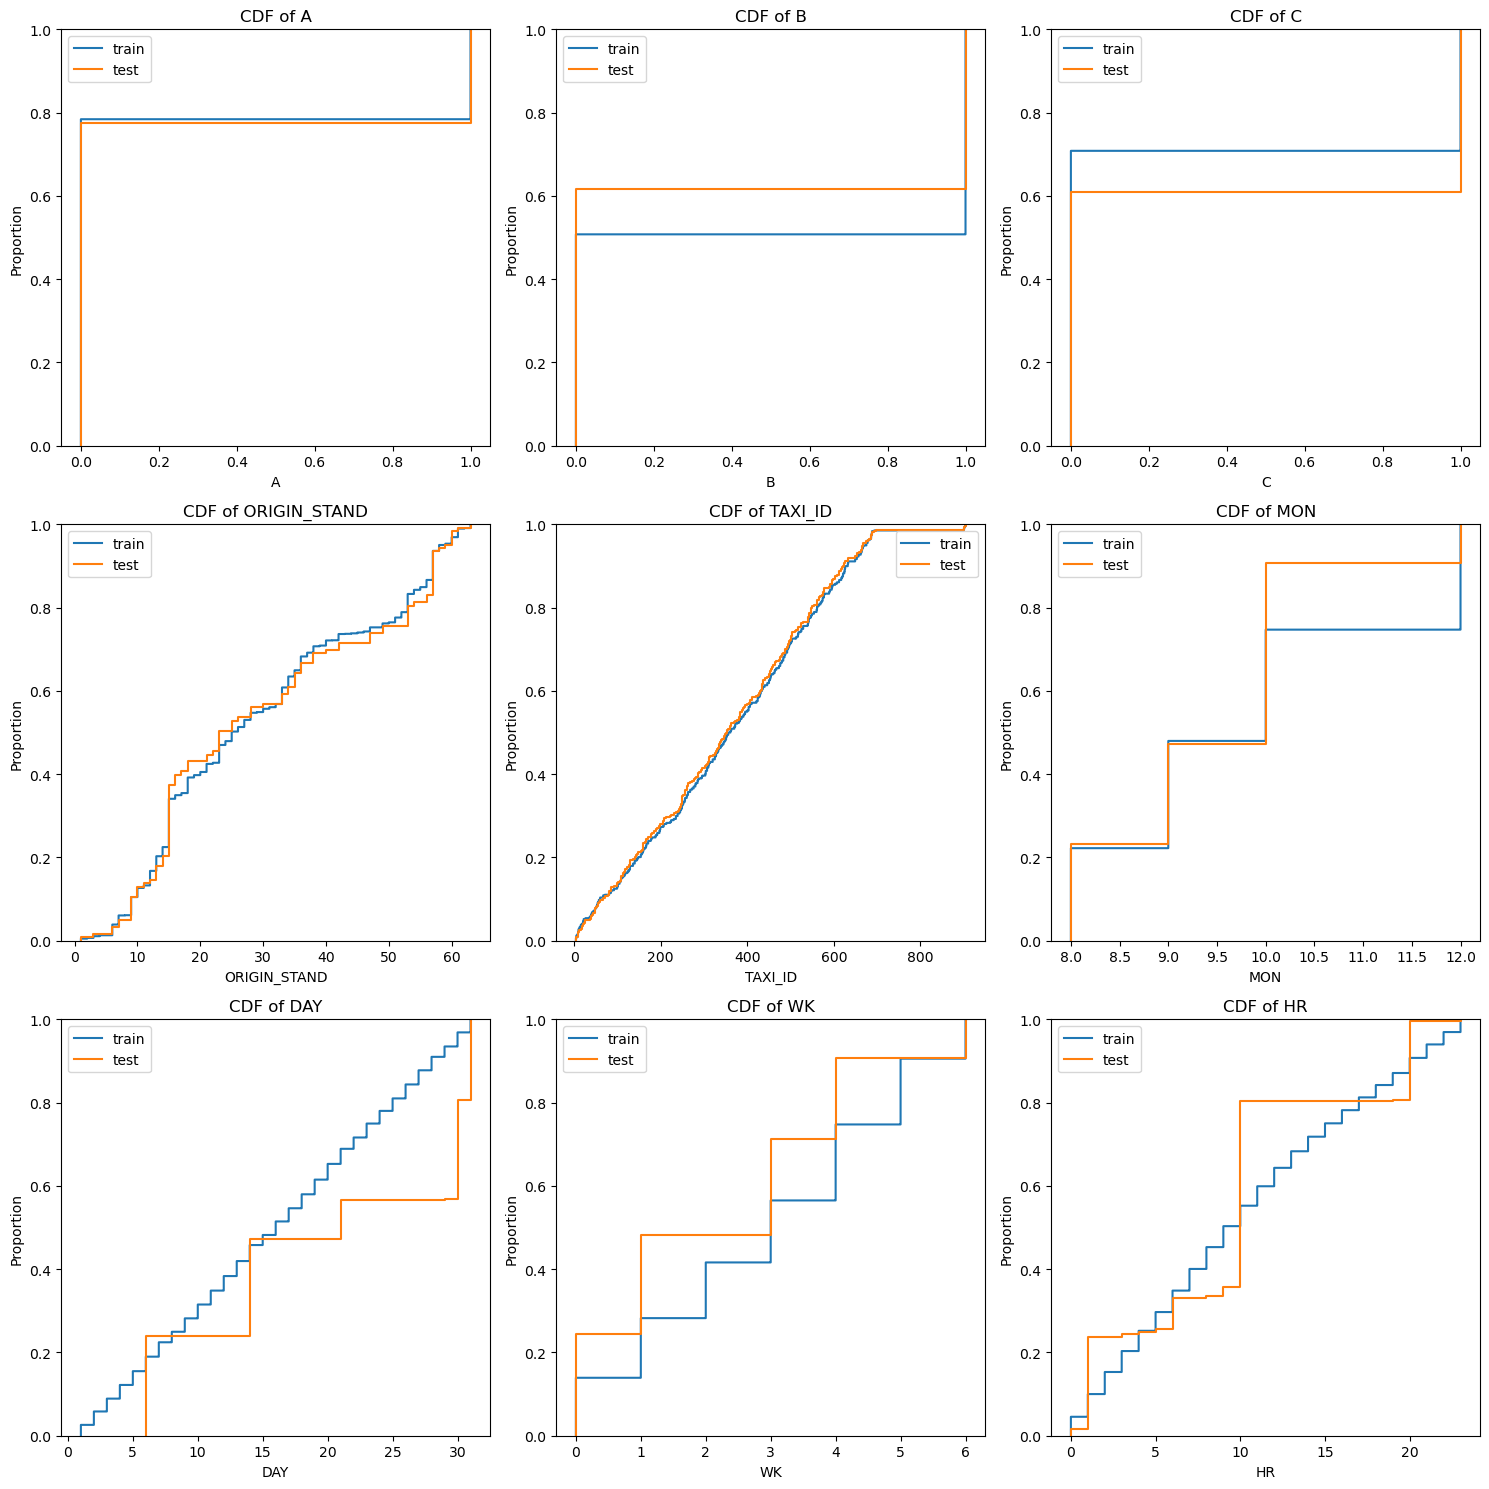

In [228]:
def plot_cdf_grid(df, smooth=False):
    num_plots = df.shape[1] - 1  # subtract 1 because we're not plotting 'is_test'
    num_cols = 3
    num_rows = num_plots // num_cols
    num_rows += num_plots % num_cols

    # set the size of the entire grid of plots
    plt.figure(figsize=(15, num_rows * 5))

    index = 1
    for column in df.columns:
        if column != 'is_test':
            plt.subplot(num_rows, num_cols, index)
            if smooth:
                sns.kdeplot(data=df[df['is_test']==0], x=column, label='train', cumulative=True, common_norm=False, common_grid=True)
                sns.kdeplot(data=df[df['is_test']==1], x=column, label='test', cumulative=True, common_norm=False, common_grid=True)
            else:
                sns.ecdfplot(data=df[df['is_test']==0], x=column, label='train')
                sns.ecdfplot(data=df[df['is_test']==1], x=column, label='test')
            plt.legend()
            plt.title(f'CDF of {column}')
            index += 1

    plt.tight_layout()
    plt.show()

plot_cdf_grid(compare_dist_df)

### Lets compare again but this time with the top misclassified results from the random forest model

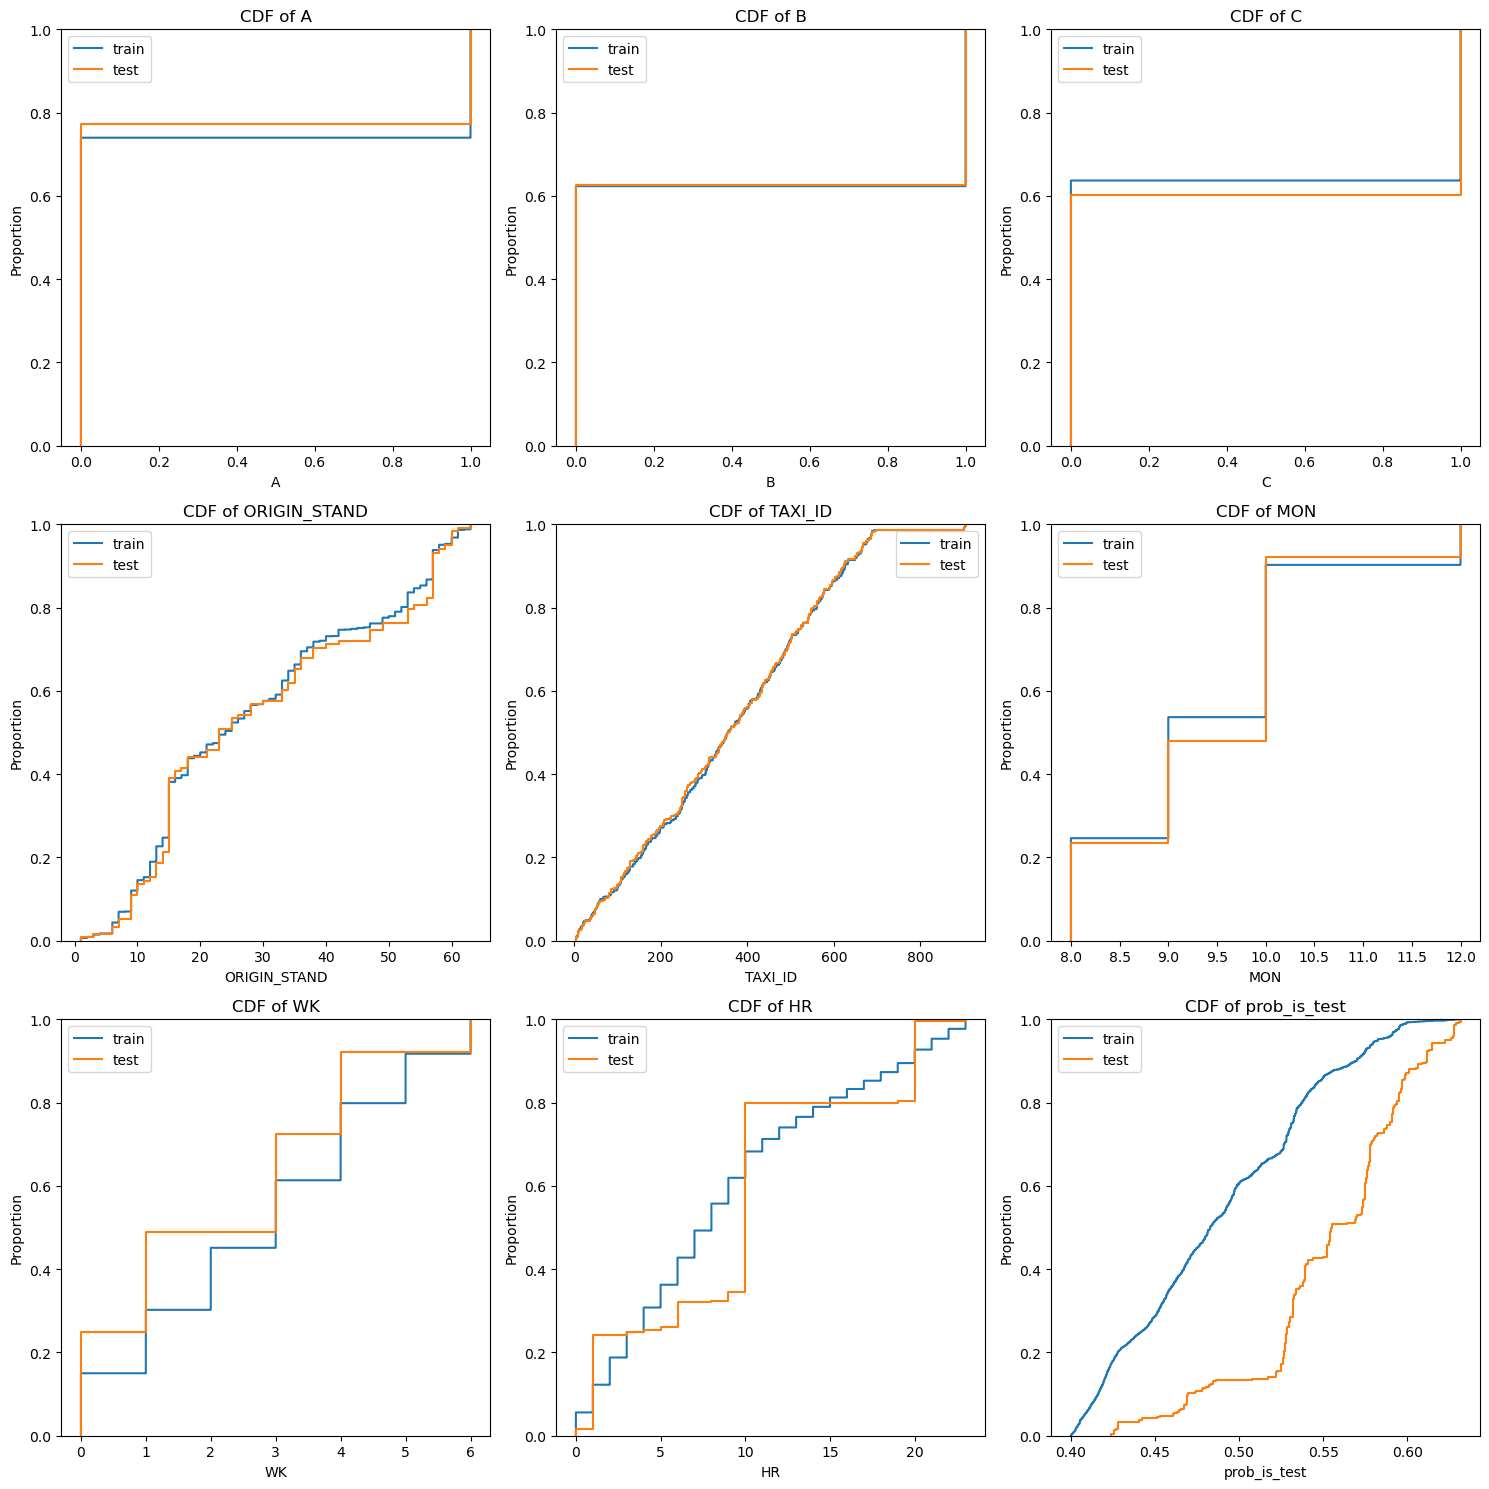

In [229]:
plot_cdf_grid(compareProbRF[compareProbRF['prob_is_test'] > 0.4])

#### Lets take a look at the distribution of hours

<Axes: xlabel='HR', ylabel='Density'>

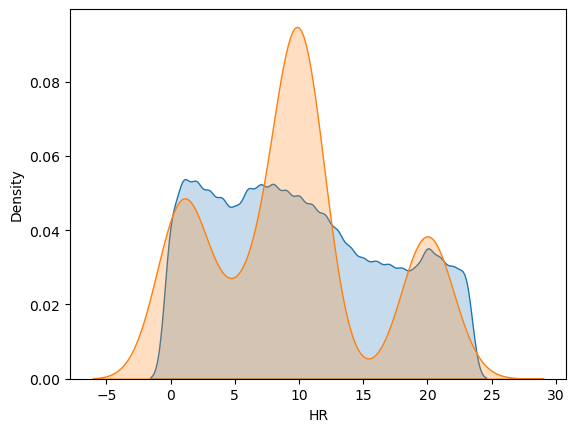

In [24]:
# The overall distribution of hours
sns.kdeplot(data=compare_dist_df[compare_dist_df['is_test']==0], x='HR', label='Train', fill=True)
sns.kdeplot(data=compare_dist_df[compare_dist_df['is_test']==1], x='HR', label='Test', fill=True)

#### Now we can break that down by CALL_TYPE

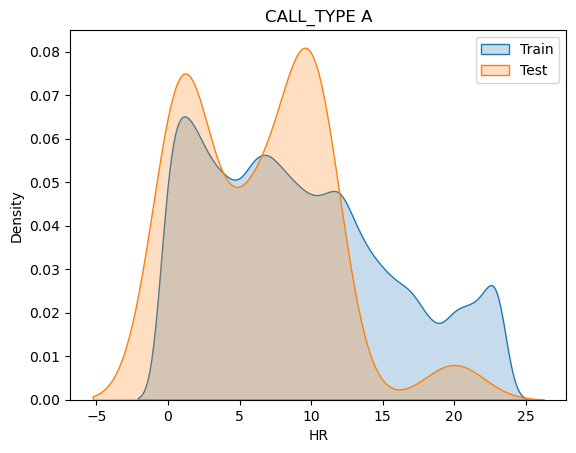

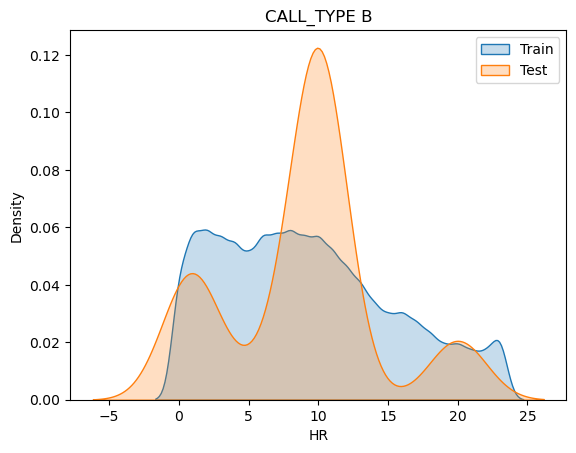

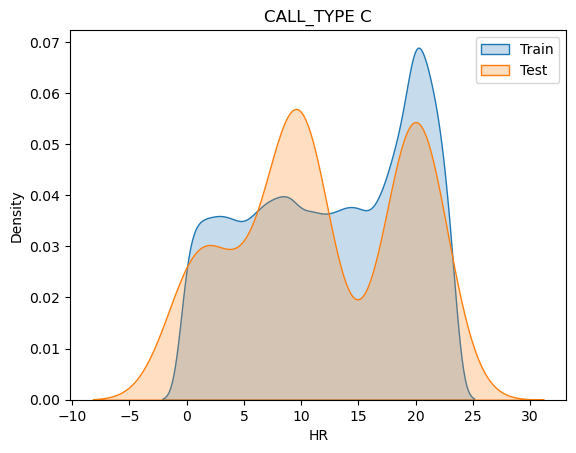

In [114]:
for column in ['A','B','C']:
    plt.figure()
    sns.kdeplot(data=compare_dist_df[(compare_dist_df['is_test']==0) & (compare_dist_df[column])], x='HR', label='Train', fill=True,)
    sns.kdeplot(data=compare_dist_df[(compare_dist_df['is_test']==1) & (compare_dist_df[column])], x='HR', label='Test', fill=True,)
    plt.legend()
    plt.title(f'CALL_TYPE {column}')
    plt.show()

#### Lets create Kernel Density Estimates for the distribution of hour for each call type and use that to sample data probabalistically

In [403]:
from sklearn.neighbors import KernelDensity

testhoursA = compare_dist_test[compare_dist_test['CALL_TYPE'] == 'A']['HR'].to_numpy().reshape(-1, 1)
testhoursB = compare_dist_test[compare_dist_test['CALL_TYPE'] == 'B']['HR'].to_numpy().reshape(-1, 1)
testhoursC = compare_dist_test[compare_dist_test['CALL_TYPE'] == 'C']['HR'].to_numpy().reshape(-1, 1)

bw = 1.75

kdeA = KernelDensity(kernel='gaussian', bandwidth=bw).fit(testhoursA)
kdeB = KernelDensity(kernel='gaussian', bandwidth=bw).fit(testhoursB)
kdeC = KernelDensity(kernel='gaussian', bandwidth=2).fit(testhoursC)

In [404]:
# Creating the probabilities for each time for each call type
hours = np.array([*range(0,24)])
hours = hours.reshape(-1, 1)

call_type_weights = compare_dist_test['CALL_TYPE'].value_counts(normalize=True).sort_index().to_list()

probabilitiesA = np.exp(kdeA.score_samples(hours))
probabilitiesA = (probabilitiesA / probabilitiesA.sum()) * call_type_weights[0]

probabilitiesB = np.exp(kdeB.score_samples(hours))
probabilitiesB = (probabilitiesB / probabilitiesB.sum()) * call_type_weights[1]

probabilitiesC = np.exp(kdeC.score_samples(hours))
probabilitiesC = (probabilitiesC / probabilitiesC.sum()) * call_type_weights[2]

In [405]:
# Returns the probability for a given CALL_TYPE and hour
def createSampleWeights(call, hour, probDict):
    return probDict[call][hour]

probDict = {'A':probabilitiesA,'B':probabilitiesB,'C':probabilitiesC}

#sample_size = 100000

probSampledTrain = compare_dist_train.copy()

# Create sampling weights for all rows
weights = probSampledTrain.apply(lambda x: createSampleWeights(x['CALL_TYPE'], x['HR'], probDict), axis=1)

# Take the sample
probSampledTrain = probSampledTrain.sample(frac=sample_frac, weights=weights)

# Combine the newly sampled df and the public test
compare_sampled_df = pd.concat([probSampledTrain, compare_dist_test]).sample(frac=1)

# Get one hot encoding of CALL_TYPE
one_hot = pd.get_dummies(compare_sampled_df['CALL_TYPE'])
compare_sampled_df = one_hot.join(compare_sampled_df.drop(columns=['CALL_TYPE']))

compare_sampled_df

,A,B,C,ORIGIN_STAND,TAXI_ID,MON,WK,HR,is_test
844563,False,True,False,18.0,136,12,5,14,0
831866,False,True,False,23.0,391,12,2,22,0
819588,True,False,False,NaN,311,12,6,13,0
423971,False,False,True,NaN,328,10,1,17,0
842721,True,False,False,NaN,529,12,5,6,0
...,...,...,...,...,...,...,...,...,...
447434,False,True,False,23.0,171,10,6,0,0
338058,False,False,True,NaN,633,9,5,21,0
177517,False,True,False,13.0,429,8,3,9,0
516842,False,True,False,33.0,675,10,5,12,0


#### Lets evaluate with random forest

In [406]:
compareSampRF, sampfeatImps = compareDistRF(compare_sampled_df)
print(compareSampRF.shape)
sampfeatImps

Train AUC-ROC: 0.847308791449759
(88107, 10)


,Feature,RF_Score
7,HR,0.274868
5,MON,0.250907
6,WK,0.231603
1,B,0.109777
3,ORIGIN_STAND,0.078487
4,TAXI_ID,0.021526
0,A,0.021155
2,C,0.011678


In [423]:
medTrain = compareSampRF

We were able to lower the AUC score marginally. It can be further reduced by increasing the kernel density bandwidth, but this might skew the training data too much

In [399]:
print((compareSampRF['prob_is_test'] >= 0.5).mean())

smallTrain = compareSampRF[compareSampRF['prob_is_test'] >= 0.5]

compareDistRF(smallTrain.drop(['prob_is_test'], axis=1))

0.2923944748998377
Train AUC-ROC: 0.7989392603534508


(            A      B      C  ORIGIN_STAND  TAXI_ID  MON  WK  HR  is_test   
 453510  False   True  False          60.0      345   10   0  10        0  \
 453804  False   True  False          54.0      617   10   0  10        0   
 453792  False   True  False          38.0      632   10   0  10        0   
 522830  False   True  False          57.0      624   10   0  10        0   
 T219    False   True  False          53.0      562   10   0  10        1   
 ...       ...    ...    ...           ...      ...  ...  ..  ..      ...   
 564371   True  False  False           NaN      686   10   2   3        0   
 460582   True  False  False           NaN      682   10   2   3        0   
 497952   True  False  False           NaN      900   10   2   2        0   
 426525   True  False  False           NaN      687   10   2   6        0   
 461426   True  False  False           NaN      687   10   2   6        0   
 
         prob_is_test  
 453510      0.701672  
 453804      0.700902  
 4

#### Large version of the data

In [416]:
largeTrain = compare_dist_train.copy()
largeTrain = largeTrain.sample(frac=0.5, weights=weights)
largeTrain = pd.concat([largeTrain, compare_dist_test]).sample(frac=1)
# Get one hot encoding of CALL_TYPE
one_hot = pd.get_dummies(largeTrain['CALL_TYPE'])
largeTrain = one_hot.join(largeTrain.drop(columns=['CALL_TYPE']))
print(largeTrain.shape)
_, largefeatimp = compareDistRF(compare_sampled_df)
largefeatimp

(162584, 9)
Train AUC-ROC: 0.847308791449759


,Feature,RF_Score
7,HR,0.274868
5,MON,0.250907
6,WK,0.231603
1,B,0.109777
3,ORIGIN_STAND,0.078487
4,TAXI_ID,0.021526
0,A,0.021155
2,C,0.011678


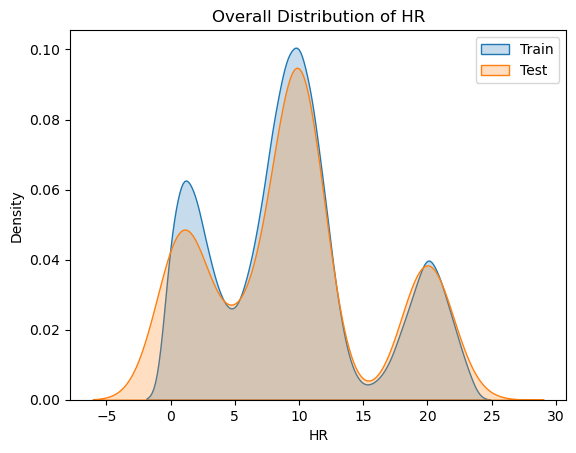

In [417]:
# The new overall distribution of hours
plt.figure()
sns.kdeplot(data=compare_sampled_df[compare_sampled_df['is_test']==0], x='HR', label='Train', fill=True)
sns.kdeplot(data=compare_sampled_df[compare_sampled_df['is_test']==1], x='HR', label='Test', fill=True)
plt.legend()
plt.title(f'Overall Distribution of HR')
plt.show()

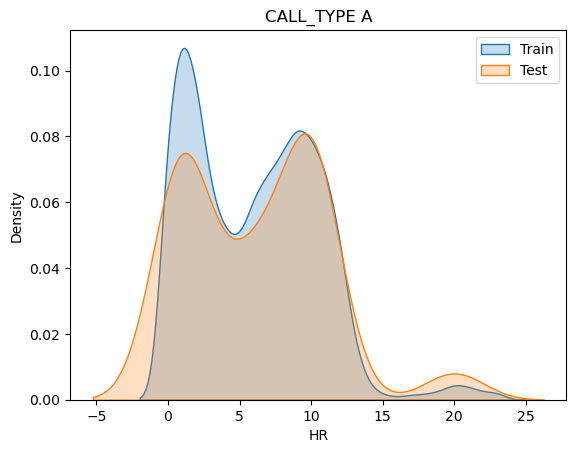

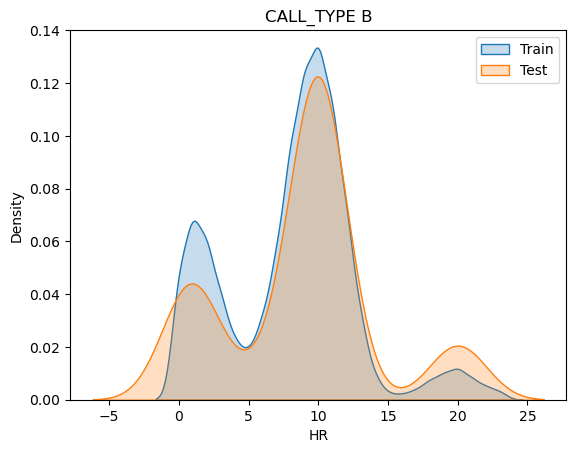

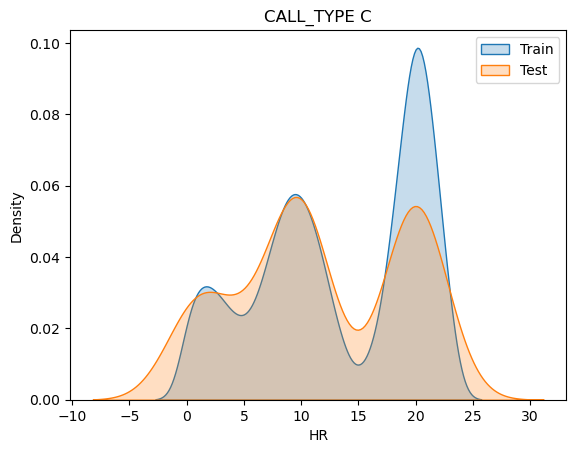

In [418]:
for column in ['A','B','C']:
    plt.figure()
    sns.kdeplot(data=compare_sampled_df[(compare_sampled_df['is_test']==0) & (compare_sampled_df[column])], x='HR', label='Train', fill=True,)
    sns.kdeplot(data=compare_sampled_df[(compare_sampled_df['is_test']==1) & (compare_sampled_df[column])], x='HR', label='Test', fill=True,)
    plt.legend()
    plt.title(f'CALL_TYPE {column}')
    plt.show()

In [428]:
smallTrain = smallTrain[smallTrain['is_test'] == 0].drop(['is_test'], axis=1)
medTrain = medTrain[medTrain['is_test'] == 0].drop(['prob_is_test','is_test'], axis=1)
largeTrain = largeTrain[largeTrain['is_test'] == 0].drop(['is_test'], axis=1)

In [433]:
smallTrain
medTrain
largeTrain.head()

,A,B,C,ORIGIN_STAND,TAXI_ID,MON,WK,HR
243493,True,False,False,NaN,256,8,5,17
347035,False,False,True,NaN,304,9,0,22
817576,False,False,True,NaN,252,12,5,22
808640,False,False,True,NaN,320,12,4,18
854000,False,True,False,47.0,383,12,0,9


### Summary
Through multiple trials we saw that the MON feature had a big impact on the models ability to discriminate between the train and test data. The same was true for DAY. We found a probability density estimate for the test data and sampled the training data based off of that to make the sets more similar.
* * * 

# Training a model to predict start location

We will use an ensemble gradient boosting multilabel regression model to predict the start locations (lat/lon) for rows where its missing

In [ ]:
# 3 different models for each call type
# first predict the starting location if not present
# predict based on time, location, and call type

locationdf.to_csv('locationdata.csv', index=None)